# Data period features

This notebook characterizes the following features for each water quality data period:
- Operational: average daily DMA inflow, number of pressure events
- Environmental: average and range of daily DMA inlet chlorine, average temperature
- Calendar: season, day of week

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from bayesian_wq_calibration.simulation import model_simulation
from bayesian_wq_calibration.constants import TIMESERIES_DIR

In [7]:
# load operational data
data_period = 10 # 19 calibration events

try:
    flow_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-flow.csv")
    pressure_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-pressure.csv")
    wq_df = pd.read_csv(TIMESERIES_DIR / f"processed/{str(data_period).zfill(2)}-wq.csv", low_memory=False)
except:
    print(f"Data period {data_period} does not exist.")

Data cleaning function:
- check that BW1 > BW12 + lag > (BW3, BW7, BW6) + respective lags & BW4 > BW9 + lag & (BW3 > BW5 + lag or BW9 > BW5 + lag) & (BW3 > BW2 + lag or BW4 > BW2 + lag) NB: all values need to be within a +/- 0.025 mg/L threshold.
- check sudden changes in readings isolated to individual sensors.

Chlorine time series plotting.

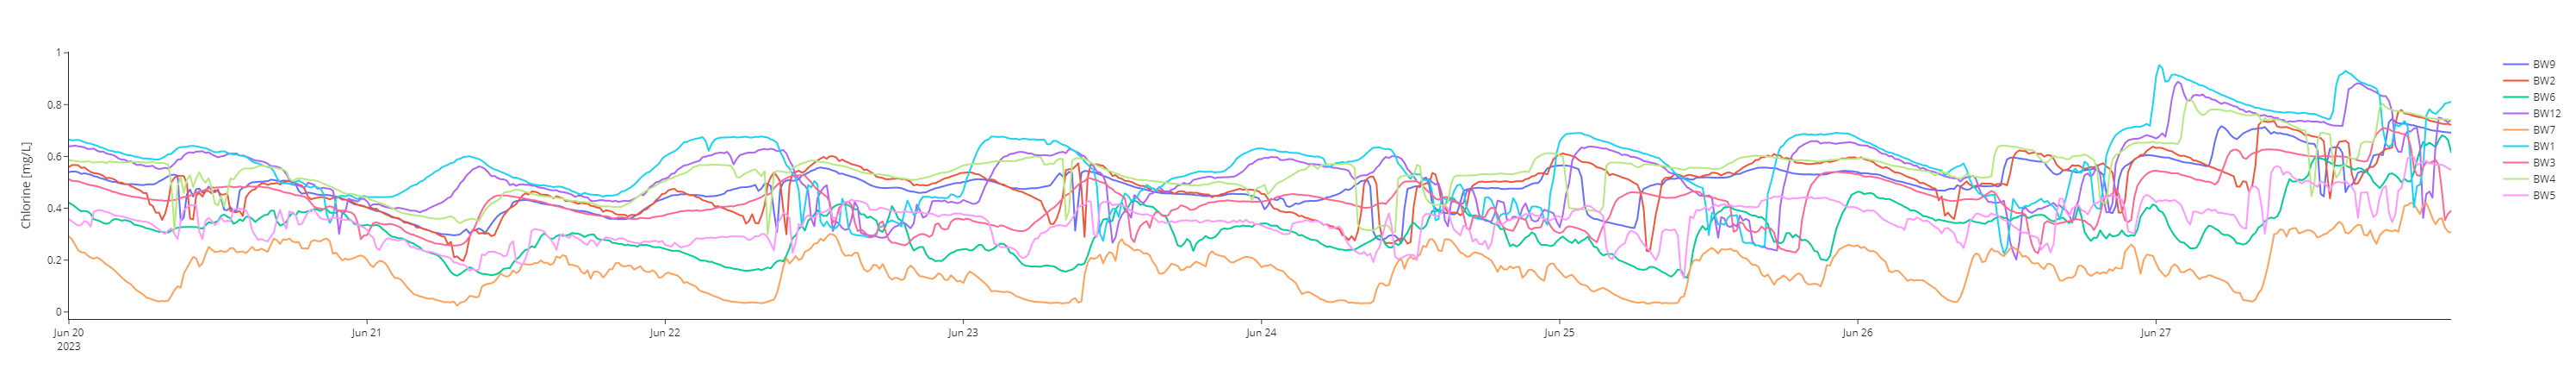

In [8]:
# chlorine data
try:
    wq_bwfl_ids = wq_df['bwfl_id'].unique()
    plot_wq_df = wq_df[(wq_df['bwfl_id'].isin(wq_bwfl_ids)) & (wq_df['data_type'] == 'chlorine')]

    fig = px.line(
        plot_wq_df,
        x='datetime',
        y='mean',
        color='bwfl_id',
    )

    fig.update_layout(
        xaxis_title='',
        yaxis_title='Chlorine [mg/L]',
        legend_title_text='',
        template='simple_white',
        height=450,
    )
    fig.show()
except:
    print("Plotting data not available.")

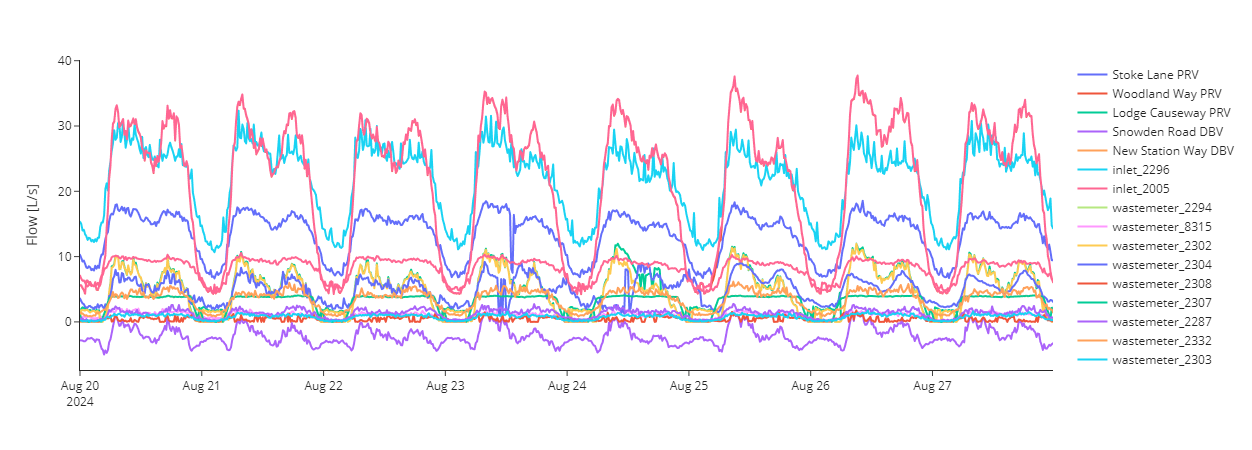

In [4]:
# flow data
try:
    flow_bwfl_ids = flow_df.dropna(subset=['mean'])['bwfl_id'].unique()
    plot_flow_df = flow_df[flow_df['bwfl_id'].isin(flow_bwfl_ids)]

    fig = px.line(
        plot_flow_df,
        x='datetime',
        y='mean',
        color='bwfl_id',
    )

    fig.update_layout(
        xaxis_title='',
        yaxis_title='Flow [L/s]',
        legend_title_text='',
        template='simple_white',
        height=450,
    )
    fig.show()
except:
    print("Plotting data not available.")

In [5]:
results = model_simulation(flow_df, pressure_df, wq_df, sim_type='age', demand_resolution='wwmd')

Error setting PRV settings. Default values used.


In [6]:
results.age['node_0310']
fig = px.line(
    results.age['node_0123']
)
fig.show()